# 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn
import warnings
from sklearn.model_selection import TimeSeriesSplit

warnings.simplefilter("ignore")

In [2]:
# Cross-sections of interest
cids_dm = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK", "USD"]
cids_em = [
    "CLP",
    "COP",
    "CZK",
    "HUF",
    "IDR",
    "ILS",
    "INR",
    "KRW",
    "MXN",
    "PLN",
    "THB",
    "TRY",
    "TWD",
    "ZAR",
]
cids = cids_dm + cids_em
cids_du = cids_dm + cids_em
cids_dux = list(set(cids_du) - {"IDR", "NZD"})
cids_xg2 = list(set(cids_dux) - {"EUR", "USD"})

In [3]:
# Quantamental categories of interest

ecos = [
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "PCREDITGDP_SJA_D1M1ML12",
    "PCREDITBN_SJA_P1M1ML12",
    "RGDP_SA_P1Q1QL4_20QMA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
]
mkts = [
    "DU02YXR_NSA",
    "DU05YXR_NSA",
    "DU02YXR_VT10",
    "DU05YXR_VT10",
    "EQXR_NSA",
    "EQXR_VT10",
    "FXXR_NSA",
    "FXXR_VT10",
    "FXCRR_NSA",
    "FXTARGETED_NSA",
    "FXUNTRADABLE_NSA",
]

xcats = ecos + mkts

In [4]:
# load the dataset:

df = pd.read_csv(
    "JPMaQS_Quantamental_Indicators.csv", index_col=0, parse_dates=["real_date"]
)

scols = ["cid", "xcat", "real_date", "value"]  # required columns
df = df[scols].copy()
display(df.tail(3))
df.info()

,cid,xcat,real_date,value
3350268,ZAR,RGDP_SA_P1Q1QL4_20QMA,2023-08-31,0.534737
3350269,ZAR,RYLDIRS02Y_NSA,2023-08-31,3.230619
3350270,ZAR,RYLDIRS05Y_NSA,2023-08-31,3.543863


<class 'pandas.core.frame.DataFrame'>
Index: 3350271 entries, 0 to 3350270
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   cid        object        
 1   xcat       object        
 2   real_date  datetime64[ns]
 3   value      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 127.8+ MB


In [5]:
display(df["xcat"].unique())
display(df["cid"].unique())
df["ticker"] = df["cid"] + "_" + df["xcat"]

array(['CPIC_SA_P1M1ML12', 'CPIC_SJA_P3M3ML3AR', 'CPIC_SJA_P6M6ML6AR',
       'CPIH_SA_P1M1ML12', 'CPIH_SJA_P3M3ML3AR', 'CPIH_SJA_P6M6ML6AR',
       'FXTARGETED_NSA', 'FXUNTRADABLE_NSA', 'FXXR_NSA', 'FXXR_VT10',
       'INFTEFF_NSA', 'INTRGDP_NSA_P1M1ML12_3MMA',
       'INTRGDPv5Y_NSA_P1M1ML12_3MMA', 'PCREDITBN_SJA_P1M1ML12',
       'PCREDITGDP_SJA_D1M1ML12', 'RGDP_SA_P1Q1QL4_20QMA',
       'RYLDIRS02Y_NSA', 'RYLDIRS05Y_NSA', 'DU02YXR_NSA', 'DU02YXR_VT10',
       'DU05YXR_NSA', 'DU05YXR_VT10', 'EQXR_NSA', 'EQXR_VT10',
       'FXCRR_NSA'], dtype=object)

array(['AUD', 'CAD', 'CHF', 'CLP', 'COP', 'CZK', 'EUR', 'GBP', 'HUF',
       'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MXN', 'NOK', 'NZD', 'PLN',
       'SEK', 'THB', 'TRY', 'TWD', 'USD', 'ZAR'], dtype=object)

## 2. Data Missingness

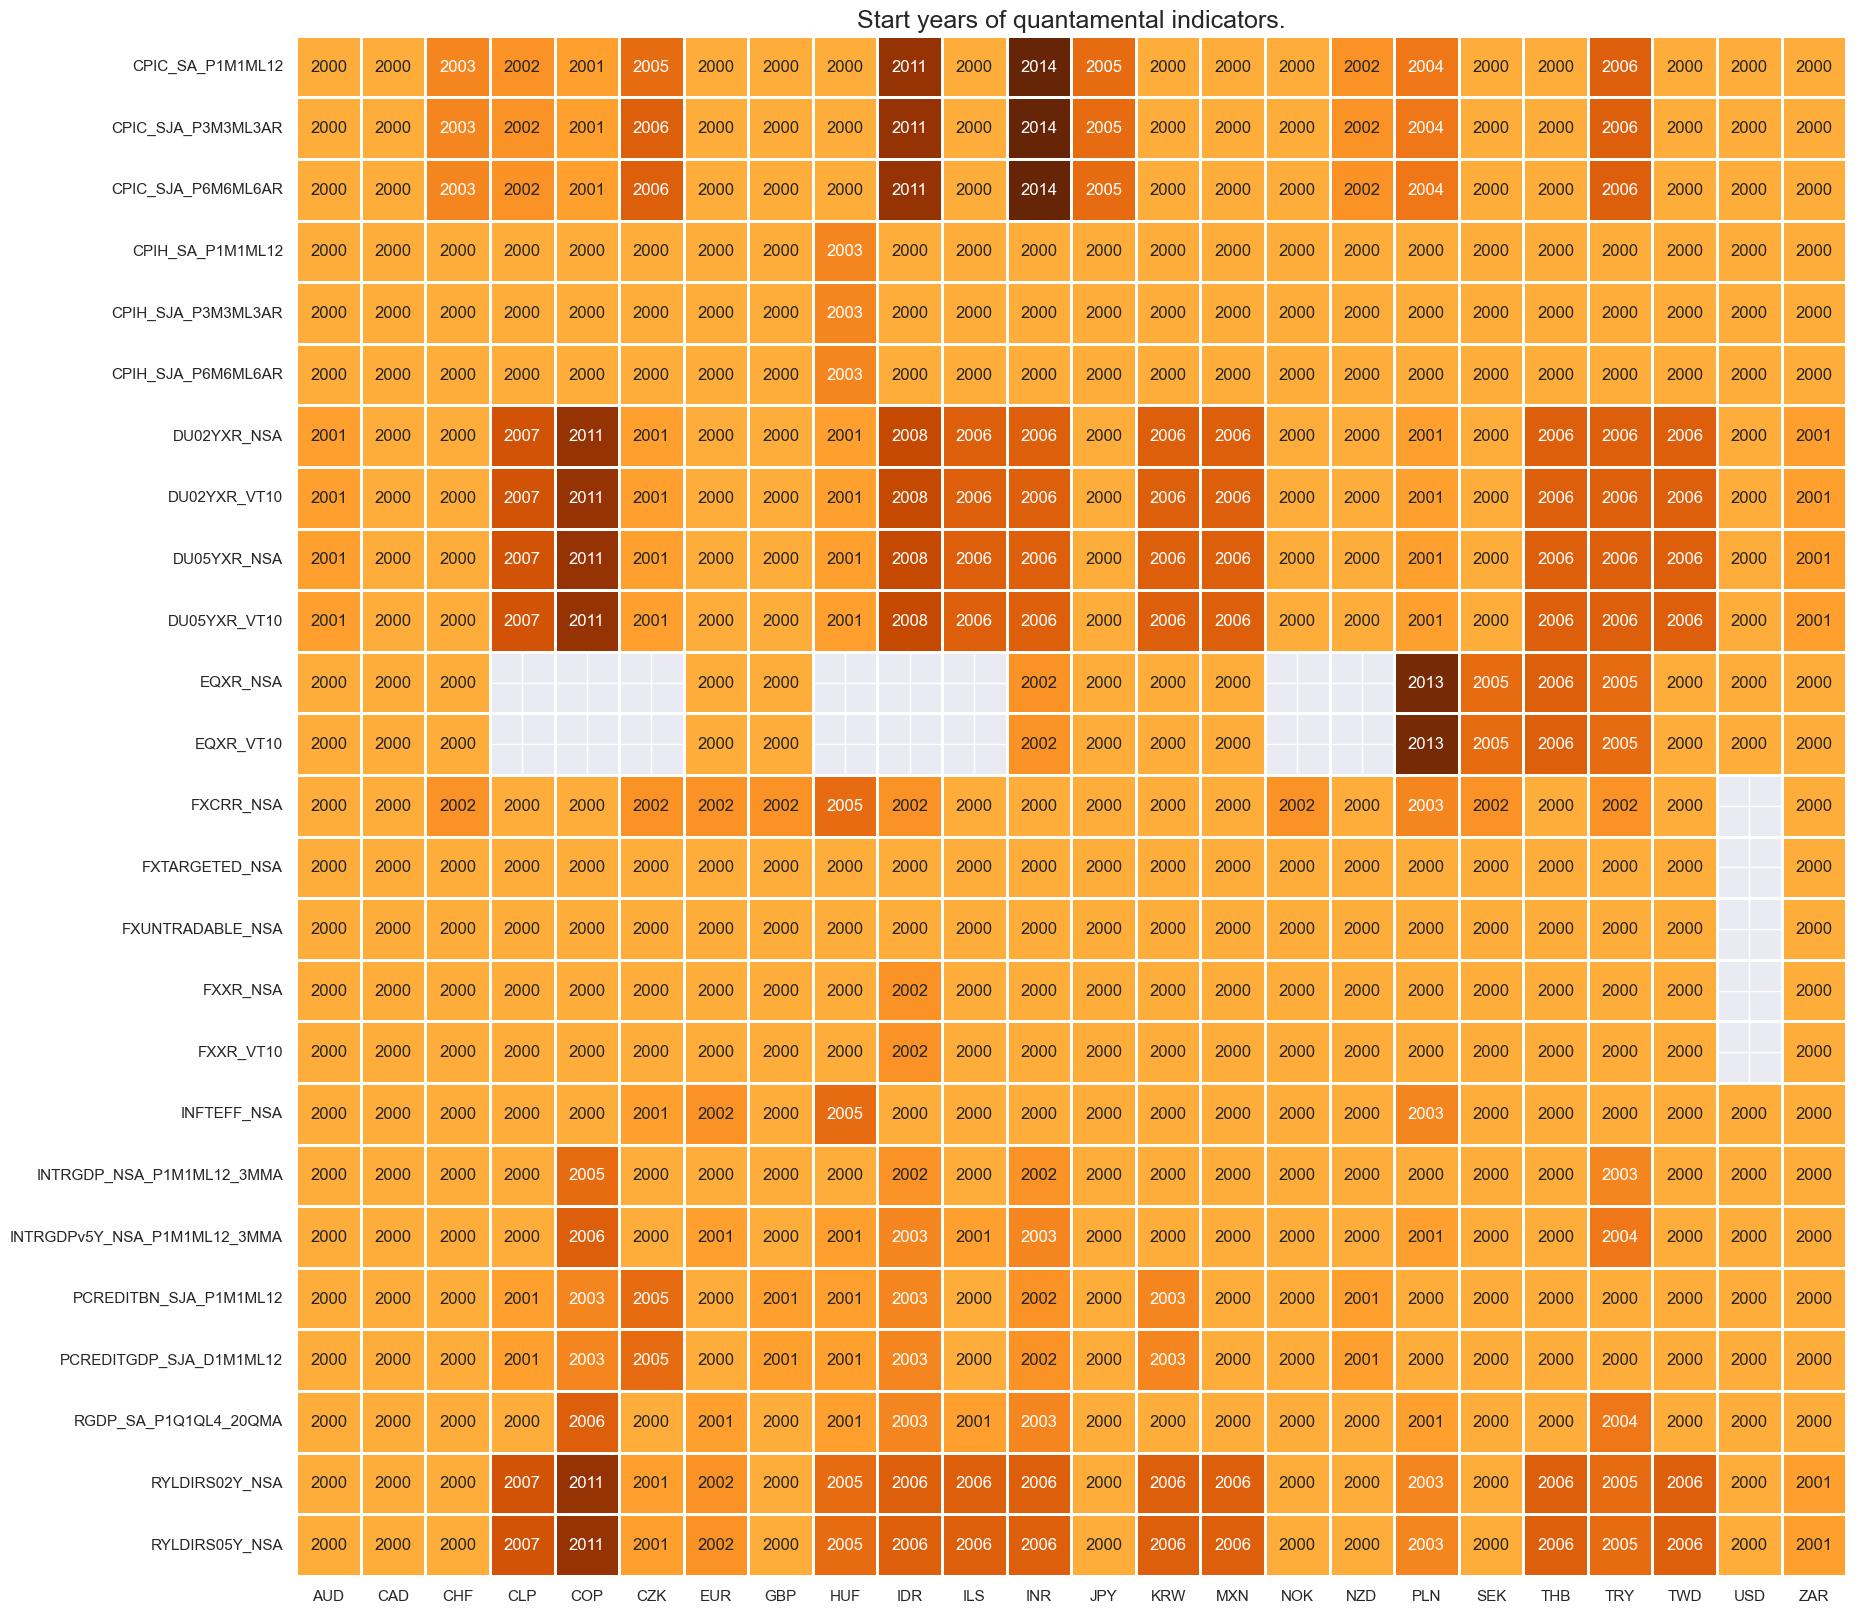

In [6]:
cids = df["cid"].unique()
x_cats = df["xcat"].unique()
dfx = msm.reduce_df(df, cids=cids, xcats=xcats)
dfs = msm.check_startyears(
    dfx,
)
msm.visual_paneldates(dfs, size=(20, 20))

In [7]:
df.set_index("real_date", inplace=True)
df.sort_index(inplace=True)
df

,cid,xcat,value,ticker
real_date,,,,
2000-01-03,AUD,CPIC_SA_P1M1ML12,1.244168,AUD_CPIC_SA_P1M1ML12
2000-01-03,AUD,CPIC_SJA_P3M3ML3AR,3.006383,AUD_CPIC_SJA_P3M3ML3AR
2000-01-03,AUD,CPIC_SJA_P6M6ML6AR,1.428580,AUD_CPIC_SJA_P6M6ML6AR
2000-01-03,AUD,CPIH_SA_P1M1ML12,1.647446,AUD_CPIH_SA_P1M1ML12
2000-01-03,AUD,CPIH_SJA_P3M3ML3AR,3.308241,AUD_CPIH_SJA_P3M3ML3AR
...,...,...,...,...
2023-08-31,ZAR,PCREDITBN_SJA_P1M1ML12,5.969562,ZAR_PCREDITBN_SJA_P1M1ML12
2023-08-31,ZAR,PCREDITGDP_SJA_D1M1ML12,3.751332,ZAR_PCREDITGDP_SJA_D1M1ML12
2023-08-31,ZAR,RGDP_SA_P1Q1QL4_20QMA,0.534737,ZAR_RGDP_SA_P1Q1QL4_20QMA


In [8]:
target = "USD_DU05YXR_VT10"
df_USD = df[df["cid"] == "USD"].copy()
df_USD = df_USD.pivot_table(
    index="real_date", columns="xcat", values="value", aggfunc="first"
)
print(df_USD.index.min(), df_USD.index.max(), sep="\n")
display(df_USD.isnull().sum())

# remove missing values (19 rows)
df_USD.dropna(inplace=True)
print(df_USD.index.min(), df_USD.index.max(), sep="\n")
df.reset_index(inplace=True)
df

2000-01-03 00:00:00
2023-08-31 00:00:00


xcat
CPIC_SA_P1M1ML12                 0
CPIC_SJA_P3M3ML3AR               0
CPIC_SJA_P6M6ML6AR               0
CPIH_SA_P1M1ML12                 0
CPIH_SJA_P3M3ML3AR               0
CPIH_SJA_P6M6ML6AR               0
DU02YXR_NSA                      0
DU02YXR_VT10                     0
DU05YXR_NSA                      0
DU05YXR_VT10                     0
EQXR_NSA                         0
EQXR_VT10                        0
INFTEFF_NSA                     19
INTRGDP_NSA_P1M1ML12_3MMA        0
INTRGDPv5Y_NSA_P1M1ML12_3MMA     0
PCREDITBN_SJA_P1M1ML12           0
PCREDITGDP_SJA_D1M1ML12          0
RGDP_SA_P1Q1QL4_20QMA            0
RYLDIRS02Y_NSA                  19
RYLDIRS05Y_NSA                  19
dtype: int64

2000-01-28 00:00:00
2023-08-31 00:00:00


,real_date,cid,xcat,value,ticker
0,2000-01-03,AUD,CPIC_SA_P1M1ML12,1.244168,AUD_CPIC_SA_P1M1ML12
1,2000-01-03,AUD,CPIC_SJA_P3M3ML3AR,3.006383,AUD_CPIC_SJA_P3M3ML3AR
2,2000-01-03,AUD,CPIC_SJA_P6M6ML6AR,1.428580,AUD_CPIC_SJA_P6M6ML6AR
3,2000-01-03,AUD,CPIH_SA_P1M1ML12,1.647446,AUD_CPIH_SA_P1M1ML12
4,2000-01-03,AUD,CPIH_SJA_P3M3ML3AR,3.308241,AUD_CPIH_SJA_P3M3ML3AR
...,...,...,...,...,...
3350266,2023-08-31,ZAR,PCREDITBN_SJA_P1M1ML12,5.969562,ZAR_PCREDITBN_SJA_P1M1ML12
3350267,2023-08-31,ZAR,PCREDITGDP_SJA_D1M1ML12,3.751332,ZAR_PCREDITGDP_SJA_D1M1ML12
3350268,2023-08-31,ZAR,RGDP_SA_P1Q1QL4_20QMA,0.534737,ZAR_RGDP_SA_P1Q1QL4_20QMA
3350269,2023-08-31,ZAR,RYLDIRS02Y_NSA,3.230619,ZAR_RYLDIRS02Y_NSA


# 3. Some EDA

xcat,CPIC_SA_P1M1ML12,CPIC_SJA_P3M3ML3AR,CPIC_SJA_P6M6ML6AR,CPIH_SA_P1M1ML12,CPIH_SJA_P3M3ML3AR,CPIH_SJA_P6M6ML6AR,DU02YXR_NSA,DU02YXR_VT10,DU05YXR_NSA,DU05YXR_VT10,EQXR_NSA,EQXR_VT10,INFTEFF_NSA,INTRGDP_NSA_P1M1ML12_3MMA,INTRGDPv5Y_NSA_P1M1ML12_3MMA,PCREDITBN_SJA_P1M1ML12,PCREDITGDP_SJA_D1M1ML12,RGDP_SA_P1Q1QL4_20QMA,RYLDIRS02Y_NSA,RYLDIRS05Y_NSA
real_date,,,,,,,,,,,,,,,,,,,,
2000-01-28,1.370914,1.657018,1.379426,2.676399,2.900698,2.310195,-0.164496,-1.656664,-0.283467,-1.140352,-3.071358,-2.706615,1.687093,4.246351,0.233658,5.821268,2.134546,3.847062,5.384795,5.651882
2000-01-31,1.370914,1.657018,1.379426,2.676399,2.900698,2.310195,-0.127303,-1.282086,-0.378624,-1.523157,2.524698,2.224874,1.687093,4.246351,0.233658,5.821268,2.134546,3.847062,5.456108,5.744223
2000-02-01,1.370914,1.657018,1.379426,2.676399,2.900698,2.310195,0.050594,0.397842,0.176418,0.501679,1.127766,0.442731,1.687093,4.307657,0.294964,5.821268,2.134546,3.847062,5.431042,5.702988
2000-02-02,1.370914,1.657018,1.379426,2.676399,2.900698,2.310195,-0.085187,-0.669854,-0.136642,-0.388570,-0.091756,-0.036021,1.687093,4.307657,0.294964,5.821268,2.134546,3.847062,5.479480,5.737156
2000-02-03,1.370914,1.657018,1.379426,2.676399,2.900698,2.310195,0.037650,0.296059,0.214934,0.611209,1.476510,0.579638,1.687093,4.307657,0.294964,5.821268,2.134546,3.847062,5.461373,5.686597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-25,4.099531,3.825302,4.495613,3.299075,2.273834,3.371062,-0.083260,-0.399182,-0.087357,-0.148746,0.644095,0.762351,3.371531,2.746773,0.598888,5.325518,2.161493,2.027798,1.430056,0.769388
2023-08-28,4.099531,3.825302,4.495613,3.299075,2.273834,3.371062,-0.000300,-0.001440,0.110547,0.188232,0.634309,0.750769,3.371531,2.746773,0.598888,5.325518,2.161493,2.027798,1.429350,0.743887
2023-08-29,4.099531,3.825302,4.495613,3.299075,2.273834,3.371062,0.218825,1.049129,0.532207,0.906205,1.451967,1.718549,3.371531,2.746773,0.598888,5.325518,2.161493,2.027798,1.313607,0.624998


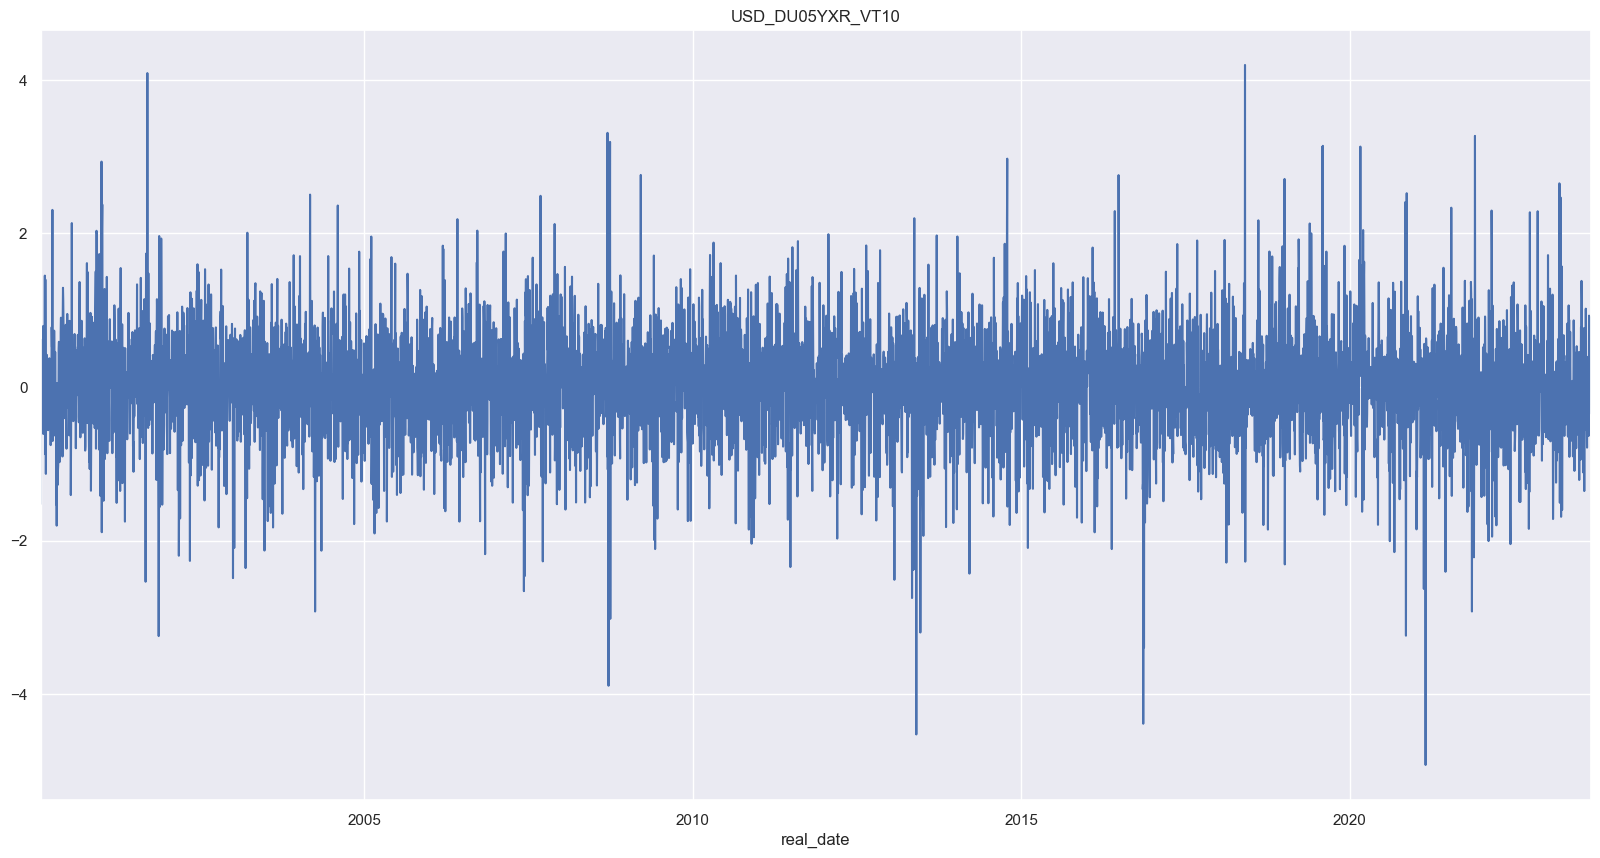

In [9]:
df_USD["DU05YXR_VT10"].plot(figsize=(20, 10), title=target)
df_USD

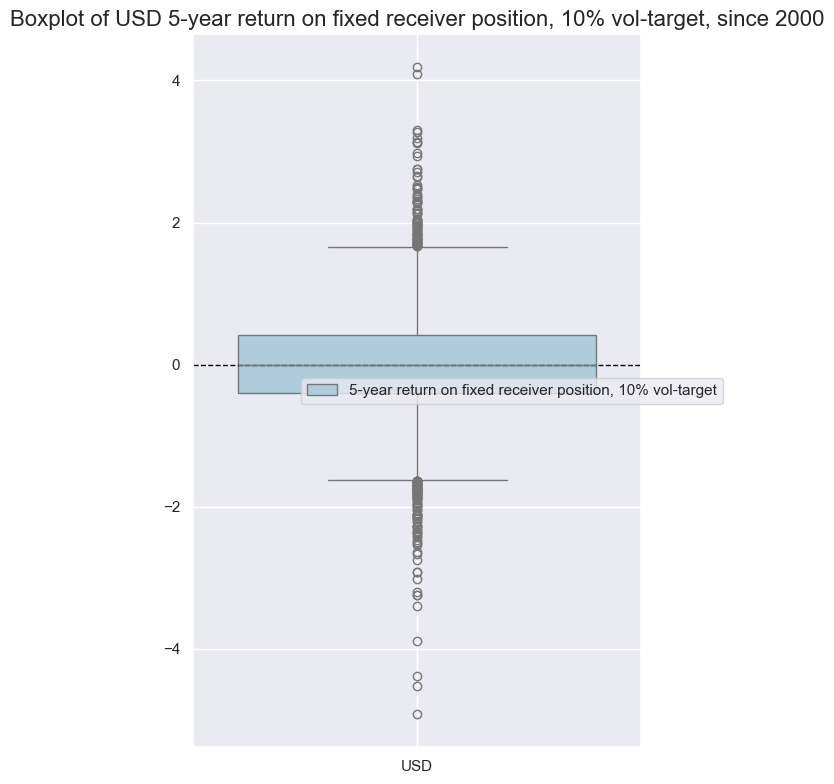

In [10]:
xcatx = ["DU05YXR_VT10"]

msp.view_ranges(
    df=df,
    xcats=xcatx,
    cids=["USD"],
    sort_cids_by="std",
    start="2000-01-01",
    kind="box",
    title="Boxplot of USD 5-year return on fixed receiver position, 10% vol-target, since 2000",
    xcat_labels=["5-year return on fixed receiver position, 10% vol-target"],
    size=(6, 8),
)

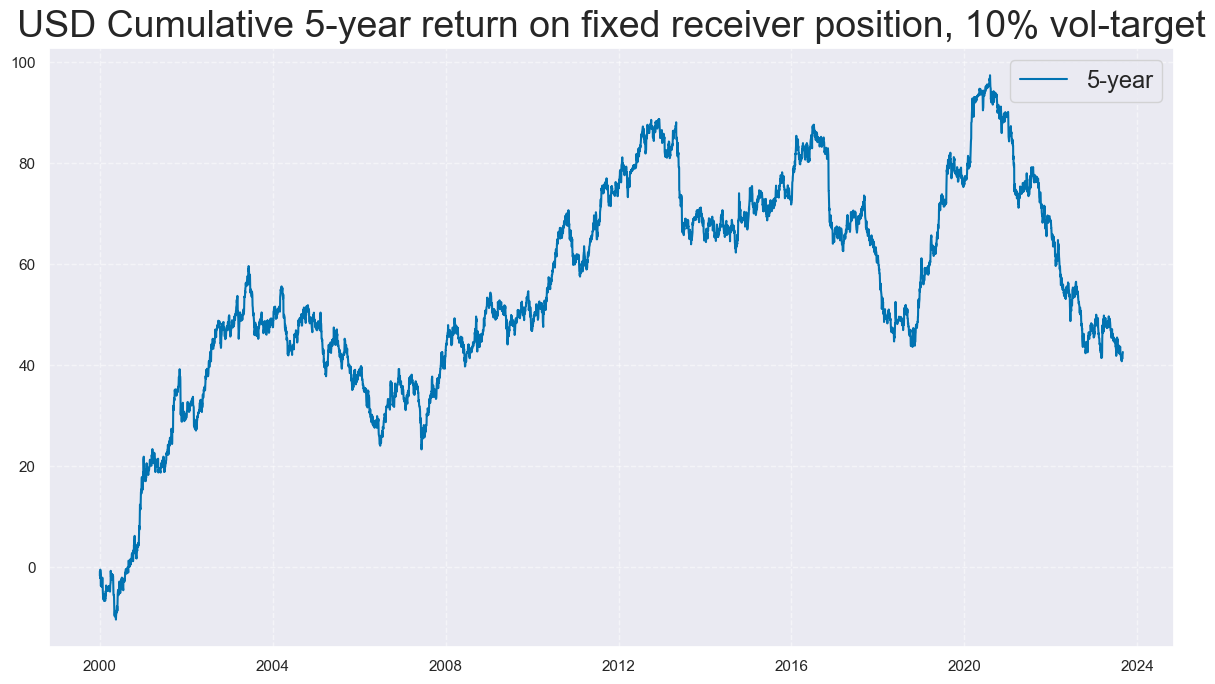

In [11]:
xcatx = ["DU05YXR_VT10"]

msp.view_timelines(
    df=df,
    xcats=xcatx,
    cids=["USD"],
    start="2000-01-01",
    title="USD Cumulative 5-year return on fixed receiver position, 10% vol-target",
    xcat_labels=["5-year"],
    cumsum=True,
    title_adj=1.03,
    title_xadj=0.47,
    label_adj=0.075,
    title_fontsize=27,
    legend_fontsize=17,
    ncol=1,
    same_y=False,
    size=(10, 7),
    aspect=1.7,
)

# 4. Baseline Models - OLS &  Ridge Regression

In [12]:
df_USD = df[df["cid"] == "USD"]
df_USD = df_USD.pivot_table(index='real_date', columns='xcat', values='value', aggfunc='first')
df_USD = df_USD.reset_index()

# Deal with missing data if any
df_USD = df_USD.dropna()

In [13]:
df_USD['real_date'] = pd.to_datetime(df_USD['real_date'])

# #Extract information about the year, month and day into three sepatate columns for OLS and Ridge Regression

df_USD['year'] = df_USD['real_date'].dt.year
df_USD['month'] = df_USD['real_date'].dt.month
df_USD['day'] = df_USD['real_date'].dt.day

In [14]:
df_USD = df_USD.drop('real_date', axis=1)
df_USD.describe()

xcat,CPIC_SA_P1M1ML12,CPIC_SJA_P3M3ML3AR,CPIC_SJA_P6M6ML6AR,CPIH_SA_P1M1ML12,CPIH_SJA_P3M3ML3AR,CPIH_SJA_P6M6ML6AR,DU02YXR_NSA,DU02YXR_VT10,DU05YXR_NSA,DU05YXR_VT10,...,INTRGDP_NSA_P1M1ML12_3MMA,INTRGDPv5Y_NSA_P1M1ML12_3MMA,PCREDITBN_SJA_P1M1ML12,PCREDITGDP_SJA_D1M1ML12,RGDP_SA_P1Q1QL4_20QMA,RYLDIRS02Y_NSA,RYLDIRS05Y_NSA,year,month,day
count,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,...,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000
mean,1.860954,1.917958,1.901179,2.551297,2.696641,2.714665,0.002060,0.008118,0.005584,0.007503,...,2.288382,-0.282726,5.424209,2.262667,2.228420,0.176653,0.812213,2011.373842,6.483347,15.738587
std,0.933937,1.084266,0.953997,1.806076,2.424426,1.792860,0.101278,0.691826,0.277403,0.703138,...,2.184487,2.242501,4.805947,2.094867,0.923210,1.710865,1.627691,6.815131,3.429001,8.804215
min,0.493345,0.244420,0.589215,-1.894241,-9.174392,-1.176354,-0.764305,-5.396459,-1.787436,-4.921224,...,-10.088247,-12.254818,-8.759398,-4.443923,0.575764,-3.274995,-1.853651,2000.000000,1.000000,1.000000
25%,1.378654,1.269311,1.405334,1.521567,1.471710,1.586951,-0.038167,-0.357070,-0.132839,-0.397433,...,1.774948,-1.036262,3.078587,1.375352,1.631584,-1.059332,-0.320729,2005.000000,4.000000,8.000000
50%,1.618247,1.670844,1.681168,2.226916,2.573539,2.376525,0.000000,0.000000,0.000000,0.000000,...,2.334357,0.133550,5.495423,2.319332,2.238561,-0.239659,0.376646,2011.000000,6.000000,16.000000
75%,1.887893,2.162592,1.961456,3.376777,3.664107,3.485576,0.041166,0.370041,0.149618,0.423697,...,3.154370,0.729191,9.018840,3.707457,2.792813,1.054157,1.987146,2017.000000,9.000000,23.000000
max,5.403876,6.419396,5.108190,8.995221,10.609495,9.610394,1.261935,6.339213,1.708877,4.191592,...,13.076745,11.004715,13.782774,6.298437,4.328053,5.539734,5.792875,2023.000000,12.000000,31.000000


In [15]:
# Selecting the Independent and Dependent Features

target = 'DU05YXR_VT10'
X = df_USD.drop('DU05YXR_VT10', axis=1)
y = df_USD['DU05YXR_VT10']

In [16]:
# Splitting the dataset

index = int(len(df_USD) * 0.9)
X_dev, X_test = X.iloc[:index], X.iloc[index:]
y_dev, y_test = y.iloc[:index], y.iloc[index:]

# Further split development set into training and validation sets
index_dev = int(len(X_dev) * 0.8)
X_train, X_validate = X_dev.iloc[:index_dev], X_dev.iloc[index_dev:]
y_train, y_validate = y_dev.iloc[:index_dev], y_dev.iloc[index_dev:]

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
model = LinearRegression()

#Fit the training dataset to the model
model.fit(X_train, y_train)

# Predictions
y_pred_train_ols = model.predict(X_train)
y_pred_test_ols = model.predict(X_test)
y_pred_validate_ols = model.predict(X_validate)

#Evaluate the performance of the trained model
r_squared = model.score(X_test, y_test)
mse_ols = mean_squared_error(y_test, y_pred_test_ols)
mae_ols = mean_absolute_error(y_test, y_pred_test_ols)
r2_ols_train = r2_score(y_train, y_pred_train_ols)
r2_ols_test = r2_score(y_test, y_pred_test_ols)
r2_ols_validate = r2_score(y_validate, y_pred_validate_ols)
average_r2_ols = (r2_ols_train + r2_ols_test + r2_ols_validate) / 3

print(f"R-Squared value on the test set = {r_squared}")
print(f"OLS Mean Squared Error: {mse_ols}")
print(f"OLS Mean Absolute Error: {mae_ols}")
print(f"OLS Average R_squared: {average_r2_ols}")

R-Squared value on the test set = 0.9516059121596534
OLS Mean Squared Error: 0.02564099235836822
OLS Mean Absolute Error: 0.11423704755142224
OLS Average R_squared: 0.9275781507750159


Text(0, 0.5, 'Predicted values')

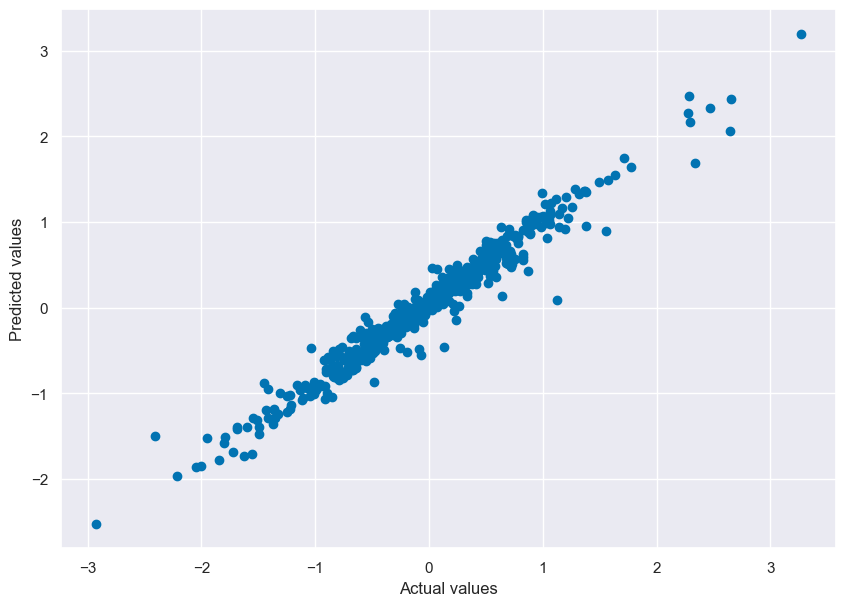

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(y_test, y_pred_test_ols, "o")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

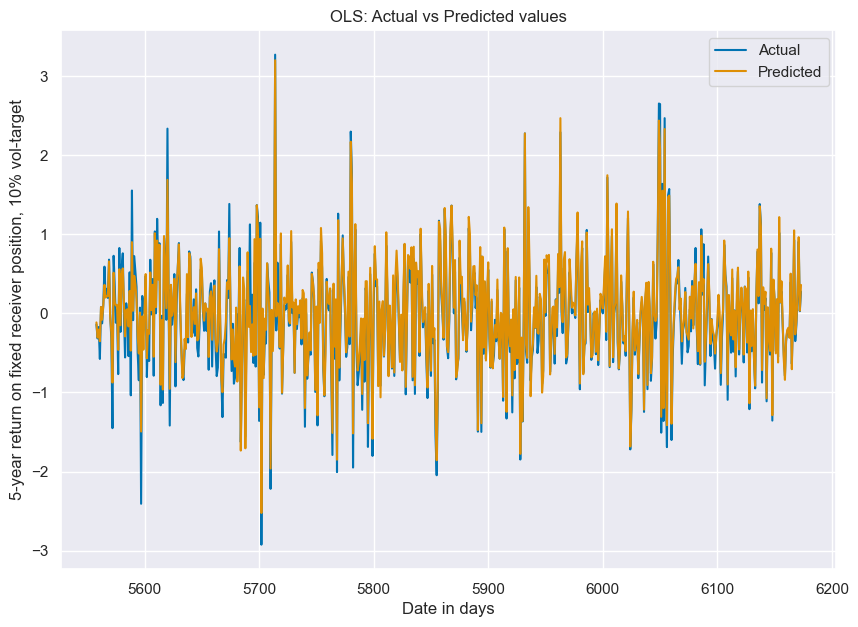

In [19]:
# plot the predicted vs actual values, over time
plt.figure(figsize=(10, 7))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_test_ols, label="Predicted")
plt.xlabel("Date in days")
plt.ylabel("5-year return on fixed receiver position, 10% vol-target")
plt.title("OLS: Actual vs Predicted values")
plt.legend()

In [20]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [21]:
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-6, 6, 13)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.alpha_
print(f"The best alpha value is : {best_alpha}")
mse = np.mean(ridge_cv.cv_values_, axis=0)

#Print MSE for each alpha value stored

for i in range(len(alphas)):
    print(f"Alpha : {alphas[i]:.6f}, MSE : {mse[i]}")

The best alpha value is : 0.01
Alpha : 0.000001, MSE : 0.03174654319731954
Alpha : 0.000010, MSE : 0.031746542939956324
Alpha : 0.000100, MSE : 0.0317465403727887
Alpha : 0.001000, MSE : 0.031746515347374014
Alpha : 0.010000, MSE : 0.03174632949813792
Alpha : 0.100000, MSE : 0.031750695936696834
Alpha : 1.000000, MSE : 0.032246705499091644
Alpha : 10.000000, MSE : 0.04153057089859305
Alpha : 100.000000, MSE : 0.06075414817356536
Alpha : 1000.000000, MSE : 0.11021897131847698
Alpha : 10000.000000, MSE : 0.32743557194592693
Alpha : 100000.000000, MSE : 0.45786880950926273
Alpha : 1000000.000000, MSE : 0.4789525612587306


In [22]:
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_dev, y_dev)

# Predictions
y_pred_dev_ridge = ridge_model.predict(X_dev)
y_pred_test_ridge = ridge_model.predict(X_test)


# Evaluation Metrics
mse_ridge = mean_squared_error(y_test, y_pred_test_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_test_ridge)
r2_ridge_train = r2_score(y_dev, y_pred_dev_ridge)
r2_ridge_test = r2_score(y_test, y_pred_test_ridge)

print(f"Ridge Test Set Mean Squared Error: {mse_ridge}")
print(f"Ridge Test Set Mean Absolute Error: {mae_ridge}")
print(f"Ridge Test Set R_squared: {r2_ridge_test}")

Ridge Test Set Mean Squared Error: 0.023351790105742534
Ridge Test Set Mean Absolute Error: 0.10031586691367368
Ridge Test Set R_squared: 0.9559264881088807


Text(0, 0.5, 'Predicted values')

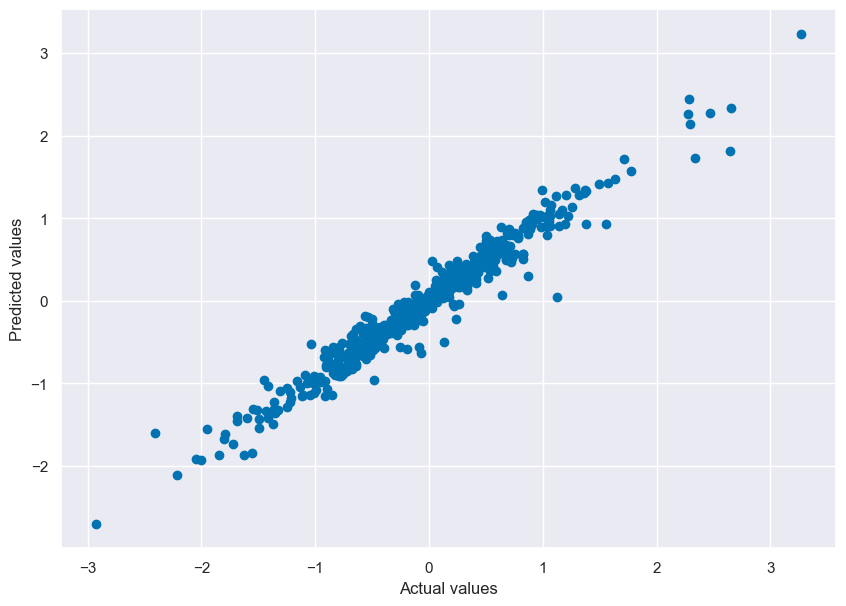

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(y_test, y_pred_test_ridge, "o")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

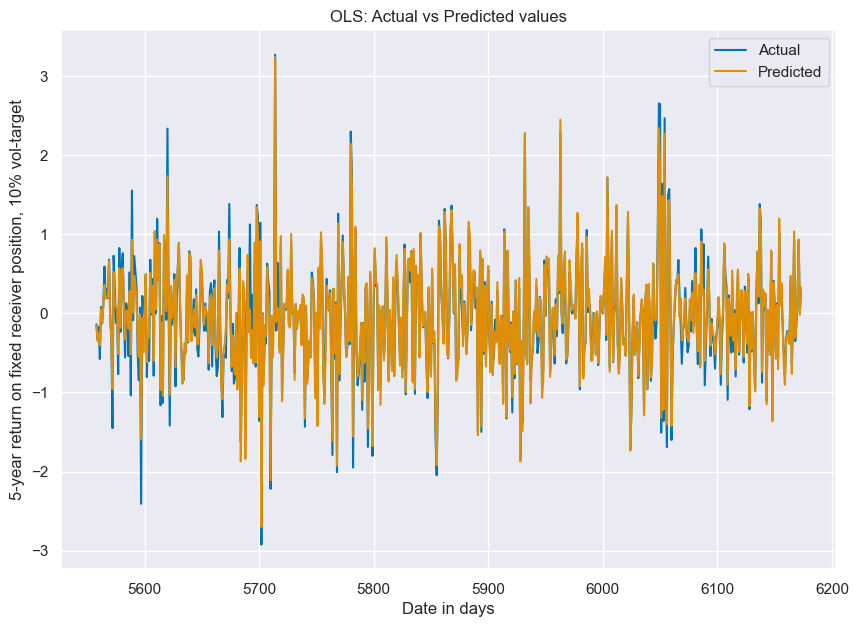

In [24]:
# plot the predicted vs actual values, over time
plt.figure(figsize=(10, 7))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_test_ridge, label="Predicted")
plt.xlabel("Date in days")
plt.ylabel("5-year return on fixed receiver position, 10% vol-target")
plt.title("OLS: Actual vs Predicted values")
plt.legend()

# 5. Lasso Regression

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [26]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-6, 6, 13)

lasso_cv = LassoCV(cv=5,alphas = alphas)
lasso_cv.fit(X_train, y_train)
mses = np.mean(lasso_cv.mse_path_, axis=1)

best_alpha = lasso_cv.alpha_
print(f"The best alpha value is : {best_alpha}")
for i in range(len(alphas)):
    print(f"Alpha : {alphas[i]:.6f}, MSE : {mses[i]}")

The best alpha value is : 0.0001
Alpha : 0.000001, MSE : 0.48200502571602166
Alpha : 0.000010, MSE : 0.48200502571602166
Alpha : 0.000100, MSE : 0.48200502571602166
Alpha : 0.001000, MSE : 0.48200502571602166
Alpha : 0.010000, MSE : 0.48200502571602166
Alpha : 0.100000, MSE : 0.48200502571602166
Alpha : 1.000000, MSE : 0.48200502571602166
Alpha : 10.000000, MSE : 0.12133823679760661
Alpha : 100.000000, MSE : 0.06619987531516225
Alpha : 1000.000000, MSE : 0.04215286362282859
Alpha : 10000.000000, MSE : 0.040466723707192814
Alpha : 100000.000000, MSE : 0.040857182344582174
Alpha : 1000000.000000, MSE : 0.040968979574516874


In [27]:
# Use the best model
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_dev, y_dev)

y_pred_best = lasso_best.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"The MSE on test set is: {mse_best}")
print(f"The R2 on test set is: {r2_best}")
print(f"The MAE on test set is: {mae_best}")

The MSE on test set is: 0.022826732202062005
The R2 on test set is: 0.9569174676293629
The MAE on test set is: 0.09902423315319887


Text(0, 0.5, 'Predicted values')

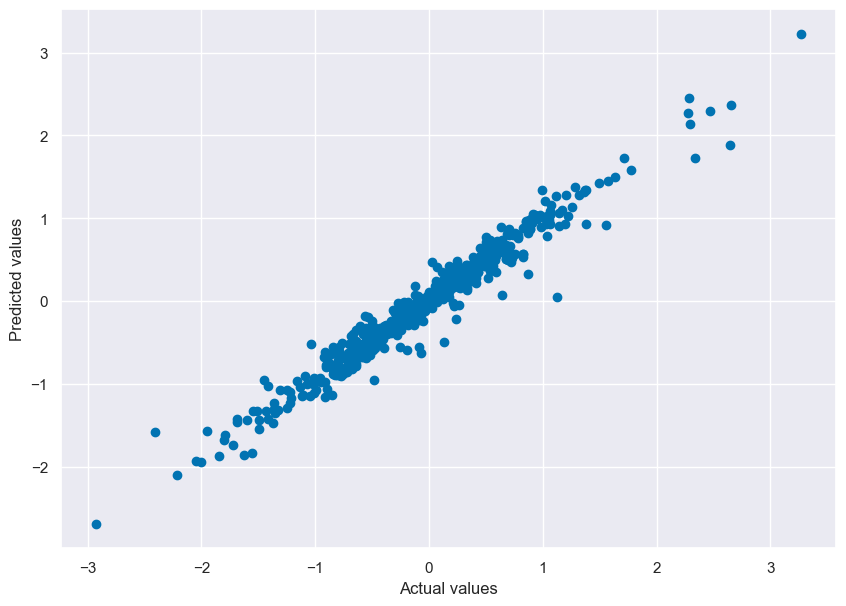

In [28]:
#plot the predicted vs actual values
plt.figure(figsize=(10, 7))
plt.plot(y_test, y_pred_best, "o")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")


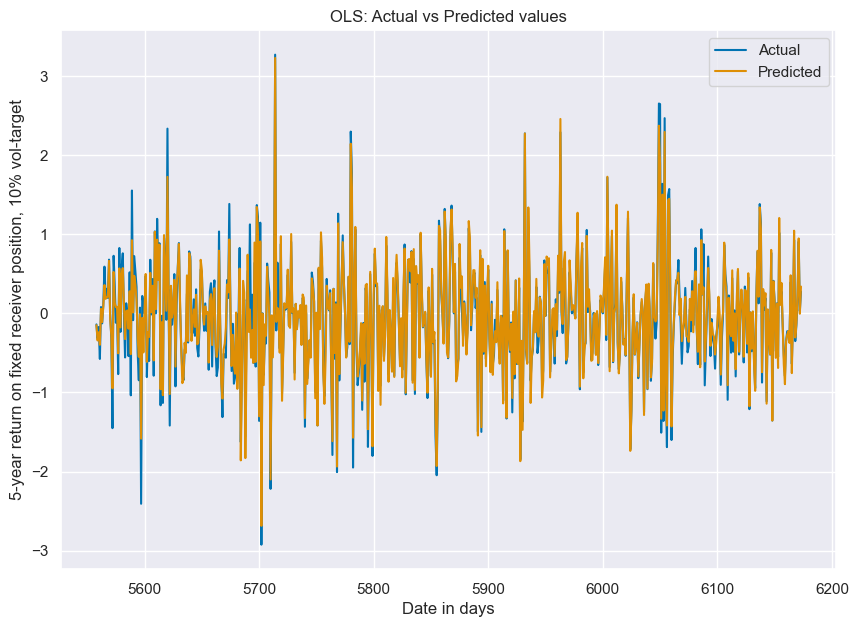

In [29]:
# plot the predicted vs actual values, over time
plt.figure(figsize=(10, 7))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_best, label="Predicted")
plt.xlabel("Date in days")
plt.ylabel("5-year return on fixed receiver position, 10% vol-target")
plt.title("OLS: Actual vs Predicted values")
plt.legend()

# 6. ARIMA Model

In [30]:
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api as sm

In [31]:
tss = TimeSeriesSplit(n_splits=4)
for train_index, test_index in tss.split(df_USD):
    development_set = df_USD.iloc[train_index]
    test_set = df_USD.iloc[test_index]

    dev_y = development_set["DU05YXR_VT10"]
    test_y = test_set["DU05YXR_VT10"]

    model_autoARIMA = auto_arima(
        dev_y,
        start_p=0,
        start_q=0,
        test="adf",  # use adftest to find  optimal 'd'
        max_p=3,
        max_q=3,  # maximum p and q
        m=1,  # frequency of series
        d=None,  # let model determine 'd'
        seasonal=False,  # No Seasonality
        start_P=0,
        D=0,
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True,
    )
    print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2633.535, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2626.909, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2625.982, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2626.536, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2625.761, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2627.581, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2627.355, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2629.294, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2623.214, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2623.873, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2624.931, Time=0.34 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2624.637, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2624.241, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2626.590, Time=0.64 sec

Best model:  ARIMA(0,0,2)(0,0,0)

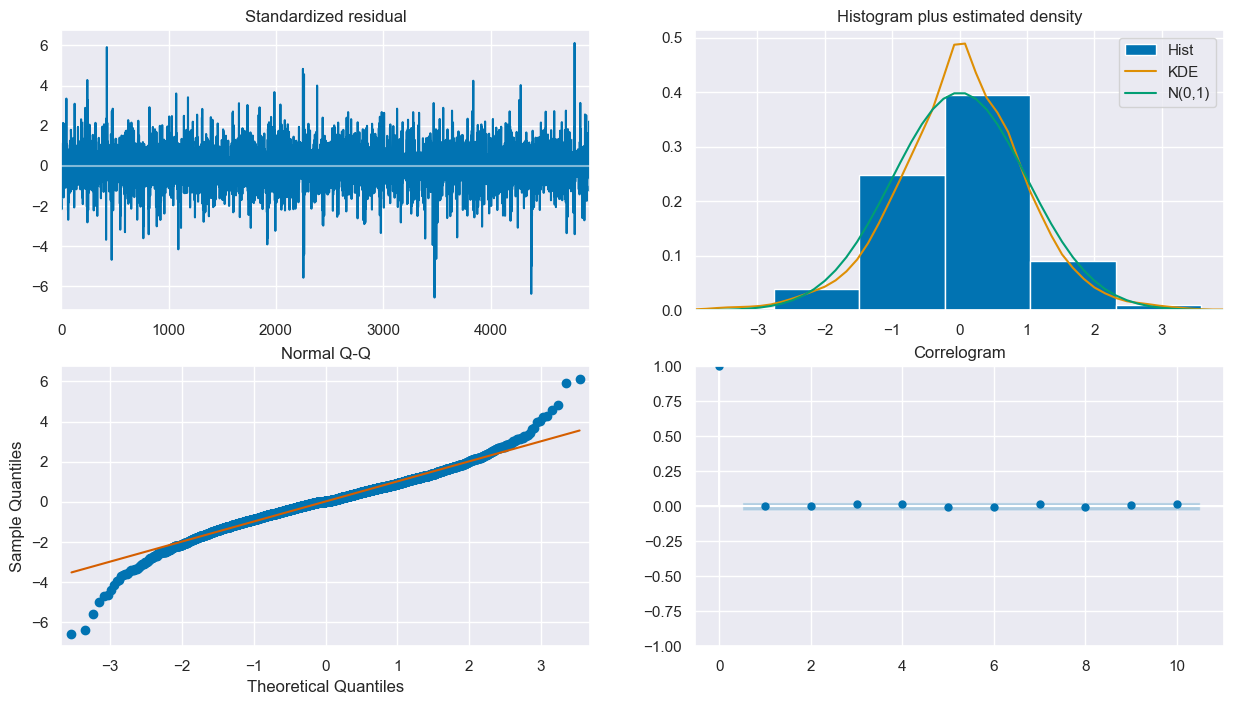

In [32]:
model_autoARIMA.plot_diagnostics(figsize=(15, 8))
plt.show()

In [33]:
model1 = sm.tsa.arima.ARIMA(dev_y, order=(0, 0, 2))
model2 = sm.tsa.arima.ARIMA(dev_y, order=(2, 0, 0))

In [34]:
fitted1 = model1.fit()
print(fitted1.summary())
fitted2 = model1.fit()
print(fitted2.summary())

                               SARIMAX Results                                
Dep. Variable:           DU05YXR_VT10   No. Observations:                 4924
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -5167.518
Date:                Sat, 09 Dec 2023   AIC                          10343.036
Time:                        21:07:51   BIC                          10369.044
Sample:                             0   HQIC                         10352.158
                               - 4924                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0112      0.010      1.149      0.251      -0.008       0.030
ma.L1          0.0200      0.012      1.665      0.096      -0.004       0.044
ma.L2         -0.0360      0.013     -2.734      0.0

In [35]:
# Forecast
fc = fitted1.forecast(3000, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_y.index)

In [36]:
print("Result for model 1: ")
print("MSE: ", mean_squared_error(test_y, fc_series))
print("RMSE: ", np.sqrt(mean_squared_error(test_y, fc_series)))

Result for model 1: 
MSE:  0.5579876224228788
RMSE:  0.7469856909090554


In [37]:
# Forecast
fc = fitted2.forecast(3000, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_y.index)
print("Result for model 2: ")
print("MSE: ", mean_squared_error(test_y, fc_series))
print("RMSE: ", np.sqrt(mean_squared_error(test_y, fc_series)))

Result for model 2: 
MSE:  0.5579876224228788
RMSE:  0.7469856909090554


# 7. LSTM Implementation

In [38]:
# LSTM packages
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

In [39]:
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            hp.Choice("units_1", [64, 128, 256]),
            activation="relu",
            input_shape=(X_train.shape[1], 1),
            return_sequences=True,
        )
    )
    model.add(BatchNormalization())
    model.add(
        Dropout(
            hp.Float("dropout_1", min_value=0.0, max_value=0.3, default=0.15, step=0.05)
        )
    )
    model.add(
        LSTM(
            hp.Choice("units_2", [8, 16, 32]), activation="relu", return_sequences=False
        )
    )
    model.add(BatchNormalization())
    model.add(
        Dropout(
            hp.Float("dropout_2", min_value=0.0, max_value=0.3, default=0.15, step=0.05)
        )
    )
    model.add(Dense(1))
    opt = hp.Choice("optimizer", ["adam", "RMSProp", "SGD"])
    if opt == "adam":
        optimizer = keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 1e-4, 5e-2, sampling="log")
        )
    elif opt == "RMSProp":
        optimizer = keras.optimizers.RMSprop(
            learning_rate=hp.Float("learning_rate", 1e-4, 5e-2, sampling="log")
        )
    else:
        optimizer = keras.optimizers.SGD(
            learning_rate=hp.Float("learning_rate", 1e-4, 5e-2, sampling="log")
        )
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"],
    )

    return model

In [40]:
# splitting into development and test by time here to avoid data leakage
# The test set should be the same across all models for fair comparison
# df_USD = df_USD.reset_index()
index = int(len(df_USD) * 0.9)
X_dev, X_test = df_USD.iloc[:index], df_USD.iloc[index:]
target = "USD_DU05YXR_VT10"
y_test = np.array(X_test["DU05YXR_VT10"])
y_test = y_test.reshape(y_test.shape[0], 1)

X_test = np.array(X_test.drop(columns=["DU05YXR_VT10"]))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

total_mse = 0.0
total_mae = 0.0
total_r2 = 0.0


# Train and Cross validation for 4 folds
tss = TimeSeriesSplit(n_splits=4)

models = []
# train a model for each fold and report the metrics
for train_index, val_index in tss.split(X_dev):
    train_set = df_USD.iloc[train_index]
    val_set = df_USD.iloc[val_index]

    y_train = np.array(train_set["DU05YXR_VT10"])
    y_train = y_train.reshape(y_train.shape[0], 1)

    X_train = np.array(train_set.drop(columns=["DU05YXR_VT10"]))
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    y_val = np.array(val_set["DU05YXR_VT10"])
    y_val = y_val.reshape(val_set.shape[0], 1)

    X_val = np.array(val_set.drop(columns=["DU05YXR_VT10"]))
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    # Hyperparameter training part
    tuner = RandomSearch(build_model, objective="val_loss", max_trials=20)
    early_stop = EarlyStopping(
        monitor="val_loss", mode="min", verbose=0, patience=25, restore_best_weights=True
    )
    tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])
    best_model = tuner.get_best_models()[0]
    print(best_model.summary())
    models.append(best_model)

Trial 20 Complete [00h 00m 43s]
val_loss: 0.07415957003831863

Best val_loss So Far: 0.04179876670241356
Total elapsed time: 00h 12m 31s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22, 128)           66560     
                                                                 
 batch_normalization (Batch  (None, 22, 128)           512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 22, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 4384      
                                                                 
 batch_normalization_1 (Bat  (None, 8)                 32        
 chNormalization)                                 

In [41]:
# get the best parameters
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'units_1': 128, 'dropout_1': 0.05, 'units_2': 8, 'dropout_2': 0.25, 'optimizer': 'adam', 'learning_rate': 0.004788036047258725}


In [42]:
res = []
y_dev = np.array(X_dev["DU05YXR_VT10"])
y_dev = y_dev.reshape(y_dev.shape[0], 1)
X_dev = np.array(X_dev.drop(columns=["DU05YXR_VT10"]))
X_dev = X_dev.reshape(X_dev.shape[0], X_dev.shape[1], 1)
for i, model in enumerate(models):
    res.append(model.evaluate(X_test, y_test))
res

20/20 [==============================] - 1s 5ms/step - loss: 0.0957 - mae: 0.2308


[[0.09572634845972061, 0.23083184659481049],
 [0.09572634845972061, 0.23083184659481049],
 [0.09572634845972061, 0.23083184659481049],
 [0.09572634845972061, 0.23083184659481049]]

In [47]:
# Retrain on the optimal hyperparameter and evaluate on the test set, using early stopping
best_model = build_model(best_hp)
best_model.fit(
    X_dev,
    y_dev,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
)
# get the best results for metrics
records = best_model.evaluate(X_test, y_test)
results = best_model.predict(X_test)


print("The following are the results of my best model on the test set")
print("---------------------------------------------------------------")
print(f"The mean square error is {str(records[0])}")
print(f"The r2 score is: {str(r2_score(y_test, results))}")
print(f"The mean absolute error is: {str(records[1])}")

total_mse += records[1]
total_r2 += r2_score(y_test, results)
total_mae += mean_absolute_error(y_test, results)

Epoch 1/50
174/174 [==============================] - 5s 17ms/step - loss: 0.6048 - mae: 0.5832 - val_loss: 0.5085 - val_mae: 0.5286
Epoch 2/50
174/174 [==============================] - 3s 16ms/step - loss: 0.2822 - mae: 0.3748 - val_loss: 0.2245 - val_mae: 0.3522
Epoch 3/50
174/174 [==============================] - 3s 15ms/step - loss: 0.2056 - mae: 0.3171 - val_loss: 0.4413 - val_mae: 0.4948
Epoch 4/50
174/174 [==============================] - 3s 15ms/step - loss: 0.1656 - mae: 0.2814 - val_loss: 0.3844 - val_mae: 0.4905
Epoch 5/50
174/174 [==============================] - 3s 15ms/step - loss: 0.1377 - mae: 0.2582 - val_loss: 0.1396 - val_mae: 0.2976
Epoch 6/50
174/174 [==============================] - 3s 15ms/step - loss: 0.1348 - mae: 0.2491 - val_loss: 0.1468 - val_mae: 0.2819
Epoch 7/50
174/174 [==============================] - 3s 15ms/step - loss: 0.1197 - mae: 0.2320 - val_loss: 0.1384 - val_mae: 0.2790
Epoch 8/50
174/174 [==============================] - 3s 15ms/step - 

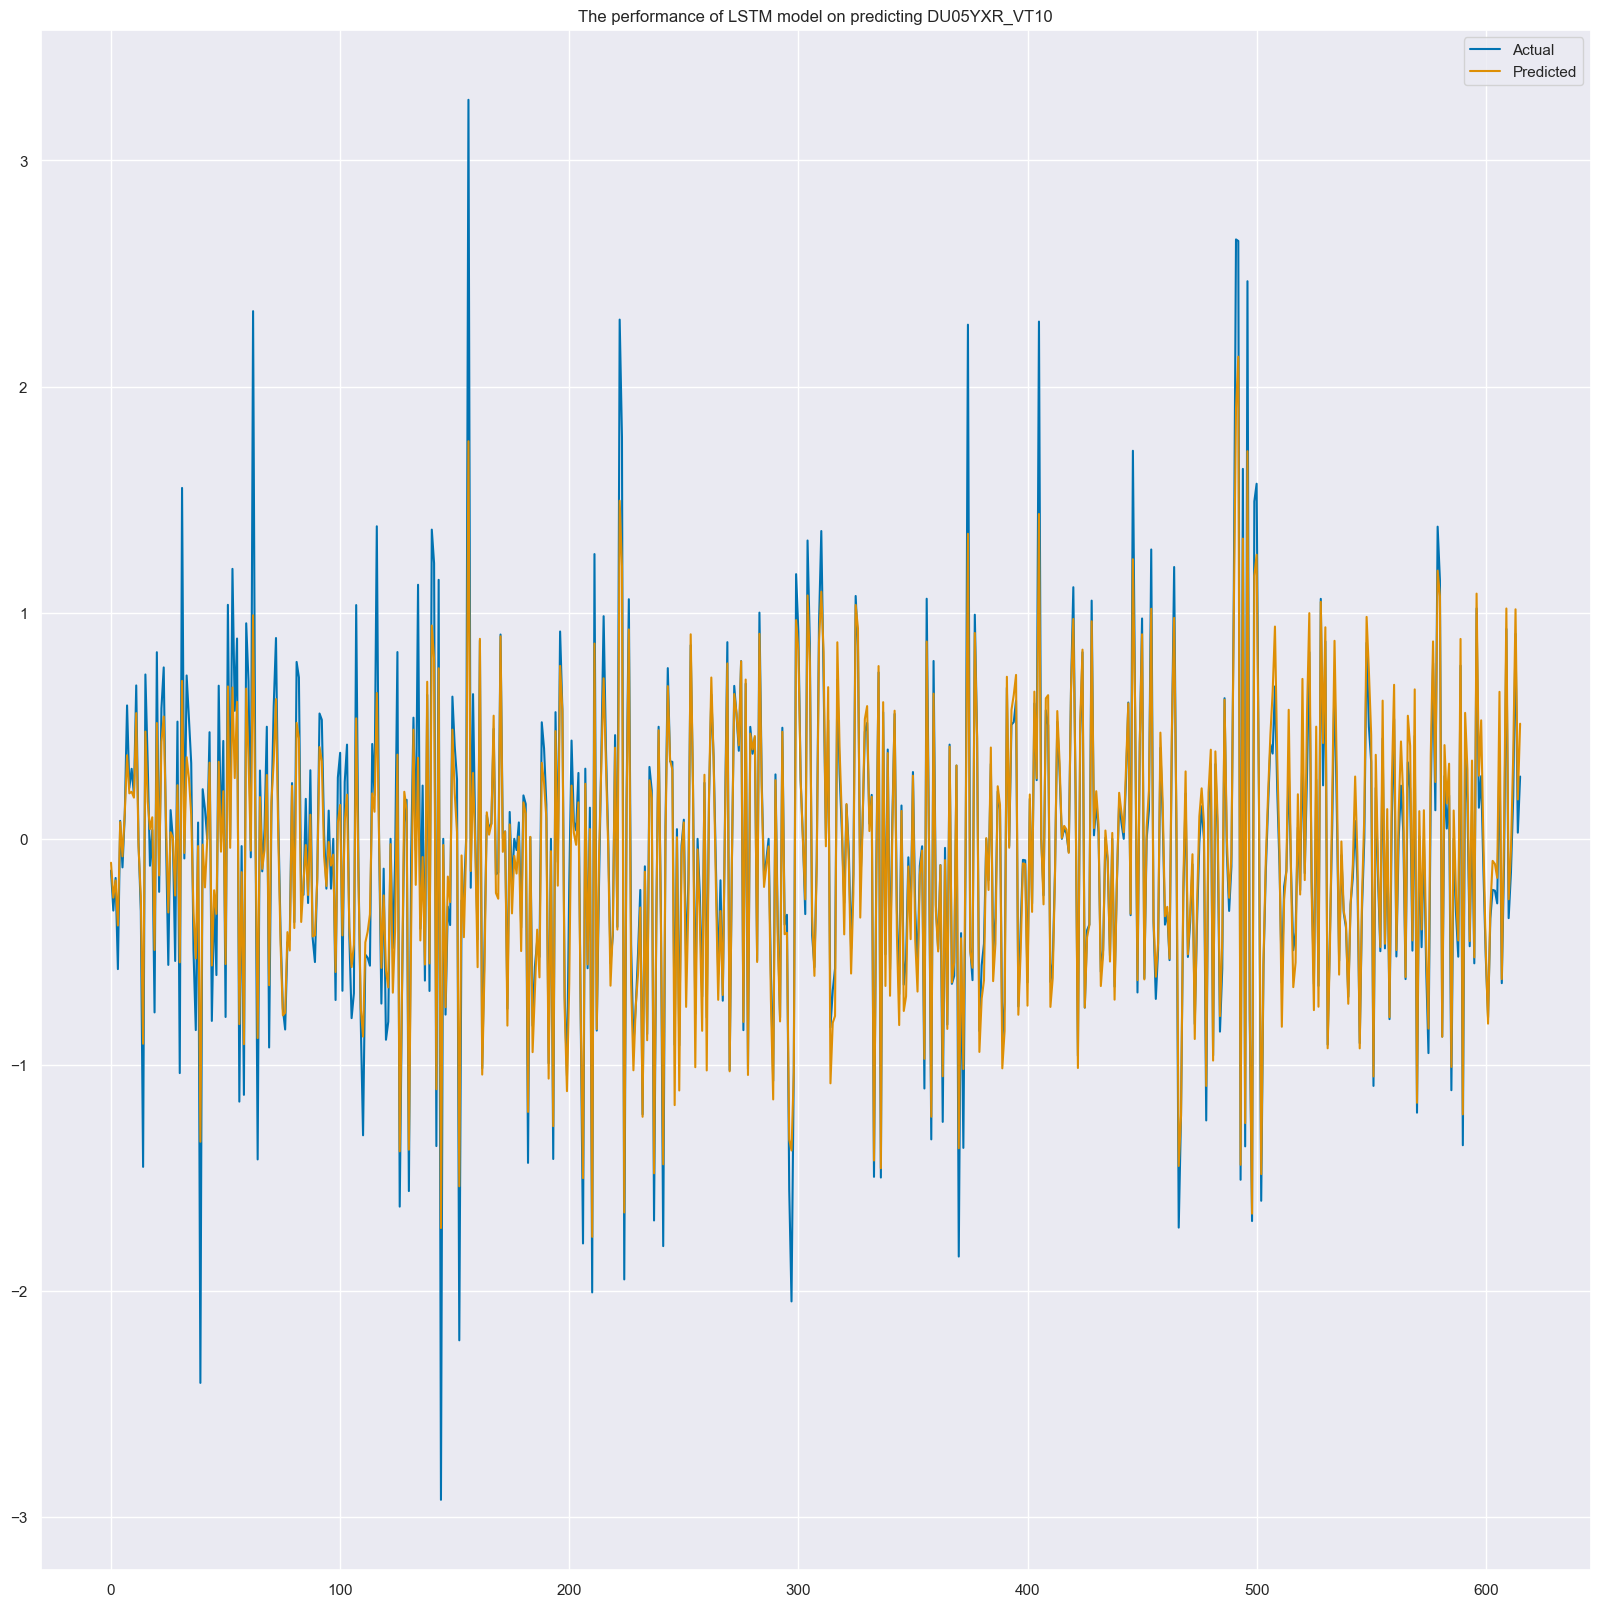

In [48]:
plt.title("The performance of LSTM model on predicting DU05YXR_VT10")
plt.plot(y_test, label="Actual")
plt.plot(results, label="Predicted")
plt.legend()
plt.show()
